In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import expm
from scipy.sparse.linalg import expm_multiply
import sys
import os

from qiskit.quantum_info import random_hermitian, Statevector, random_clifford

from Certification import MyStateVector, certify
from utils import Experiment, Plotter

$$H_{\text{Rydberg}} = \frac{\Omega}{2}\sum_i X_i - \Delta \sum_i N_i + \Omega \sum_{i<j} \big(\frac{R_b}{a|i-j|}\big)^6 N_iN_j \text{ where } N_i \equiv |r_i\rangle\langle r_i|$$ 

In [6]:
experiments = []
all_results = {}
all_fidelities = {}

for nq in [3, 5, 7]:
    exp = Experiment(num_qubits=nq,
                     num_runs=10000,
                     num_norms=20,
                     perturbation_mode="per_qubits",  # "per_qubits" or "per_run"
                     psi0_type="clifford")              # "random" or "clifford"
    experiments.append(exp)
    res, fid = exp.run(Omega=1, Delta=2.5, rb=1.5, tau=0.1, a=1)
    all_results[nq] = res
    all_fidelities[nq] = fid

print("All runs complete.")


Running for 3 qubits
Total runs: 200000
Finished 3-qubit run in 8.51 min.                                                                                       

Running for 5 qubits
Total runs: 200000
Finished 5-qubit run in 15.19 min.                                                                                      

Running for 7 qubits
Total runs: 200000
Finished 7-qubit run in 110.46 min.                                                                                     
All runs complete.


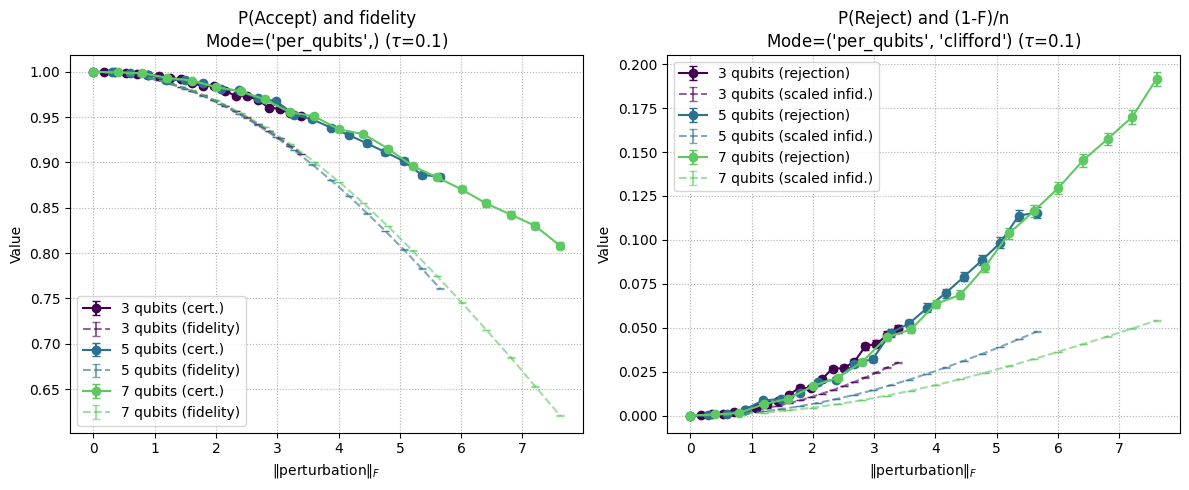

In [7]:
plotter = Plotter(experiments)
plotter.plot()

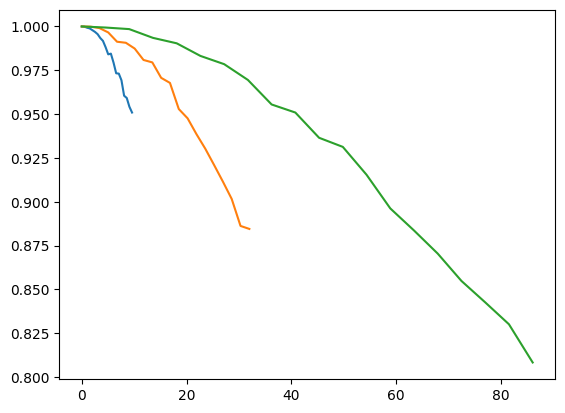

In [8]:
plt.plot(np.array(list(experiments[0].results.keys())), [np.mean(l) for l in list(experiments[0].results.values())])
plt.plot(np.array(list(experiments[1].results.keys())), [np.mean(l) for l in list(experiments[1].results.values())])
plt.plot(np.array(list(experiments[2].results.keys())), [np.mean(l) for l in list(experiments[2].results.values())])